In [1]:
import torch
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Exploring CNN - Fine Tuning
## Improving CNN Performances

Exploring:
 - Data Augmentation
 - Hyperparamenter Tuning 
     - Learning Rate Finder
     - Learing Rate Scheduler

 Helper Functions Code Credit - Udacity DL Nanodegree Program

---
### Data Augmentation

Here we write two functions that create appropriate transforms for the training, validation and test dataset, and then create the relative dataloaders.

As usual, complete the code in the sections marked with `# YOUR CODE HERE`.

In [3]:
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import random
import multiprocessing
from helpers import get_train_val_data_loaders, get_test_data_loader
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

# Let's write a function that gives us the transforms so we can optimize the hyperparameters
def get_transforms(rand_augment_magnitude):

    # These are the per-channel mean and std of CIFAR-10 over the dataset
    mean = (0.49139968, 0.48215827, 0.44653124)
    std = (0.24703233, 0.24348505, 0.26158768)

    # Define our transformations
    return {
        "train": T.Compose(
            [
                # All images in CIFAR-10 are 32x32. We enlarge them a bit so we can then
                # take a random crop
                T.Resize(40),
                
                # take a random part of the image
                T.RandomCrop(32),
                
                # Horizontal flip is not part of RandAugment according to the RandAugment
                # paper
                T.RandomHorizontalFlip(0.5),
                
                # Use RandAugment
                # RandAugment has 2 main parameters: how many transformations should be
                # applied to each image, and the strength of these transformations. This
                # latter parameter should be tuned through experiments: the higher the more
                # the regularization effect.
                # Setup a T.RandAugment transformation using 2 as num_opts, and the
                # rand_augment_magnitude input parameter as magnitude. 
                # Use T.InterpolationMode.BILINEAR as interpolation. Look at the pytorch
                # manual if needed: 
                # https://pytorch.org/vision/main/generated/torchvision.transforms.RandAugment.html
                
                # YOUR CODE HERE
                T.RandAugment(
                    num_ops=2,
                    magnitude=rand_augment_magnitude,
                    interpolation=T.InterpolationMode.BILINEAR,
                ),
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
        "valid": T.Compose(
            [
                # Both of these are useless, but we keep them because
                # in a non-academic dataset you will need them
                T.Resize(32),
                T.CenterCrop(32),
                
                # Convert to tensor and apply normalization:
                
                # YOUR CODE HERE
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
        # Identical to the valid set in this case
        "test": T.Compose(
            [
                T.Resize(32),
                T.CenterCrop(32),
                
                # Convert to tensor and apply normalization:
                
                # YOUR CODE HERE
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
    }


def get_data_loaders(batch_size, valid_size, transforms, num_workers, random_seed=42):
    
    # Reseed random number generators to get a deterministic split. This is useful
    # when comparing experiments, so you'll know they all run on the same data.
    # In principle you should repeat this a few times (cross validation) to see
    # the variability of your measurements, but we won't do this here for simplicity
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Get the CIFAR10 training dataset from torchvision.datasets and set the transforms
    # We will split this further into train and validation in this function
    train_data = datasets.CIFAR10("data", train=True, download=True, transform=transforms['train'])
    valid_data = datasets.CIFAR10("data", train=True, download=True, transform=transforms['valid'])

    # Compute how many items we will reserve for the validation set
    n_tot = len(train_data)
    split = int(np.floor(valid_size * n_tot))

    # compute the indices for the training set and for the validation set
    shuffled_indices = torch.randperm(n_tot)
    train_idx, valid_idx = shuffled_indices[split:], shuffled_indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)
    # NOTE that here we use train_data for the train dataloader but valid_data
    # for the valid_loader, so the respective transforms are applied
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
    )
    
    test_data = datasets.CIFAR10("data", train=False, download=True, transform=transforms['test'])
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )
    
    return {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Model Definition

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, n_classes=10):

        super(Net, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            # Add batch normalization (BatchNorm2d) here
            # YOUR CODE HERE
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3, padding=1),  # -> 32x16x16
            # Add batch normalization (BatchNorm2d) here
            # YOUR CODE HERE
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 32x8x8
            
            nn.Conv2d(32, 64, 3, padding=1),  # -> 64x8x8
            # Add batch normalization (BatchNorm2d) here
            # YOUR CODE HERE
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 64x4x4
            
            # Since we are using BatchNorm and data augmentation,
            # we can go deeper than before and add one more conv layer
            nn.Conv2d(64, 128, 3, padding=1),  # -> 128x4x4
            # Add batch normalization (BatchNorm2d) here
            # YOUR CODE HERE
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 128x2x2
            
            nn.Flatten(),  # -> 1x64x4x4
            
            nn.Linear(128 * 2 * 2, 500),  # -> 500
            nn.Dropout(0.5),
            # Add batch normalization (BatchNorm1d, NOT BatchNorm2d) here
            # YOUR CODE HERE
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, n_classes),
        )

    def forward(self, x):
        
        # Just call the model on x here:
        # YOUR CODE HERE
        return self.model(x)


# create a complete CNN
model = Net()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

---
# Pre-Training Learning Rate Finder

- Custom LR finder will use small amount of data (0.4% of train dataset), run it through the network with random weights (the weights will be erased before real training), use a PyTorch LR Scheduler to change the LR and finalize a decent lr. The goal is to find a stable learning rate range - a rough range
- Empirically, lr_finder helps avoid very bad choices (like an LR that’s too high, causing divergence) if one is not used. Even though it's not perfect, it gets us into a reasonable range faster than manual tuning.


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


Training:  32%|█████████▊                     | 199/625 [00:22<00:48,  8.80it/s]


(2.320445707866124, 2.443653022270935)

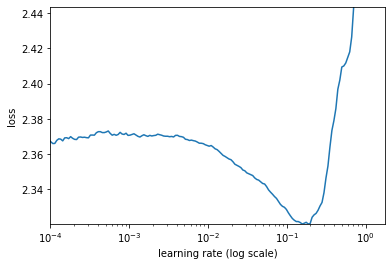

In [6]:
# lr_finder definition is in the lr_finder.py file
from lr_finder import lr_finder
import matplotlib.pyplot as plt

batch_size = 64
valid_size = 0.2
num_workers = multiprocessing.cpu_count()

transforms = get_transforms(rand_augment_magnitude=9)
data_loaders = get_data_loaders(batch_size, valid_size, transforms, num_workers)

# Range  and number of steps for the learning rate
min_lr = 1e-5
max_lr = 1
n_steps = min(len(data_loaders['train']), 200)

# specify loss function (categorical cross-entropy)
loss = nn.CrossEntropyLoss()

losses = lr_finder(min_lr, max_lr, n_steps, loss, model, data_loaders)

# Plot the results
plt.plot(losses.keys(), losses.values())
plt.xscale("log")
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")

# Adjust the range on the y-axis to see things more clearly
plt.xlim([1e-4, None])
plt.ylim([min(losses.values()), np.percentile(list(losses.values()), 97)])

##### Selection of the Learning Rate
- You do not pick the lr of the lowest loss point since it is just before loss spikes and so an unstable point. Lowest point is on the edge of divergence and using it might cause instability
- You pick an lr at the middle of the sloping line. Left of it is flat (flat indicating slow convergence) while right shows divergence. The middle of the slope is high enough to learn fast but low enough to remain stable.

##### Empirical Best Practices
Many deep learning practitioners have found that picking a LR about 10× smaller than the min-loss LR gives the best convergence. This avoids sudden spikes while still benefiting from fast learning.

---
## Learning Rate Scheduler + Hyperparameter Optimization

Use Learning Rate Scheduler, that changes the learning rate as the training progresses.

We need to include the LR Scheduler in the trainer function. 


In [2]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from helpers import train_one_epoch, valid_one_epoch
import torch.optim


def cnn_trainer(data_loaders, model, optimizer, loss, n_epochs, save_path, interactive_tracking=False):
    
    # This is a plotting function
    def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
        """Add title xlabel and legend to single chart"""
        ax.set_title(group_name)
        ax.set_xlabel(x_label)
        ax.legend(loc="center right")
        
    # initialize tracker for minimum validation loss
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None

    valid_loss_min = None
    logs = {}

    # Learning rate scheduler: setup a learning rate scheduler that
    # reduces the learning rate when the validation loss reaches a plateau.
    # torch.optim.lr_scheduler.ReduceLROnPlateau, with a threshold of 0.01. 
    
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(  
        optimizer, "min", verbose=True, threshold=0.01  
    )  

    for epoch in range(1, n_epochs + 1):

        train_loss = train_one_epoch(
            data_loaders["train"], model, optimizer, loss
        )

        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss)

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or (
                (valid_loss_min - valid_loss) / valid_loss_min > 0.01
        ):

            # Save the weights to save_path
            torch.save(model.state_dict(), save_path)  

            valid_loss_min = valid_loss

        # Update learning rate, i.e., make a step in the learning rate scheduler
        # Using validation loss, so that the lr scheduler changes lr when the validation loss is not decreasing anymore           
        scheduler.step(valid_loss)  

        # Log the losses and the current learning rate
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss
            logs["lr"] = optimizer.param_groups[0]["lr"]

            liveloss.update(logs)
            liveloss.send()

## MLFLOW - Tracking parameters and experiments

In [3]:
import mlflow 
from helpers import one_epoch_test

def train_one_model(learning_rate, rand_augment_magnitude, n_epochs):
    
    transforms = get_transforms(rand_augment_magnitude=rand_augment_magnitude)
    data_loaders = get_data_loaders(batch_size, valid_size, transforms, num_workers)
    model = Net()
    
    if train_on_gpu:
        model.cuda()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss = nn.CrossEntropyLoss()
    
    with mlflow.start_run():
        
        cnn_trainer(data_loaders, model, optimizer, loss, n_epochs, "best_val_loss.pt", interactive_tracking=True)
        
        # Restore best validation loss
        model.load_state_dict(torch.load('best_val_loss.pt'))
        
        # Test model on *validation* set
        val_loss, preds, actuals = one_epoch_test(data_loaders['valid'], model, loss)
        
        # mlflow.log_param to log parameters
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("rand_augment_magnitude", rand_augment_magnitude)
        
        # mlflow.log_metric to log validation loss
        mlflow.log_metric("val_loss", val_loss)
        
        val_accuracy = (np.array(preds)==np.array(actuals)).sum() / len(actuals)
        
        # mlflow to log the validation accuracy as a metric
        mlflow.log_metric("val_accuracy", val_accuracy)
        
        # mlflow.log_artifact to asve the file
        mlflow.log_artifact("best_val_loss.pt")